# Setup

This project requires Python 3.7 or above

In [69]:
import sys

assert sys.version_info >= (3, 7)

It also requires Scikit-Learn >= 1.0.1:

In [70]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

And TenserFlow >= 2.8:

In [71]:
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

In [72]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [73]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "ann"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# From Biological to Artificial Neurons

## The Perceptron

In [74]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

iris = load_iris(as_frame=True)
X = iris.data[['petal length (cm)', 'petal width (cm)']].values
y = (iris.target == 0)  # Iris setosa

per_clf = Perceptron(random_state=42)
per_clf.fit(X, y)

X_new = [[2, 0.5], [3, 1]]
y_pred = per_clf.predict(X_new)

In [75]:
y_pred

array([ True, False])

The `Perceptron` is equivalent to a `SGDClassifier` with `loss="perceptron"`, no regularization, and a constant learning rate equal to 1:

In [76]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(loss='perceptron', penalty=None, learning_rate='constant', eta0=1,
                        random_state=42)
sgd_clf.fit(X, y)
assert (sgd_clf.coef_ == per_clf.coef_).all()
assert (sgd_clf.intercept_ == per_clf.intercept_).all()

In [77]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def plot_decision_boundary(model, X, y=None, xlabel=None, ylabel=None):
    a = -model.coef_[0, 0] / model.coef_[0, 1]
    b = -model.intercept_ / model.coef_[0, 1]
    axes = [0, 5, 0, 2]
    x0, x1 = np.meshgrid(
        np.linspace(axes[0], axes[1], 500).reshape(-1, 1),
        np.linspace(axes[2], axes[3], 200).reshape(-1, 1),
    )
    X_new = np.c_[x0.ravel(), x1.ravel()]
    y_pred = per_clf.predict(X_new)
    zz = y_pred.reshape(x0.shape)
    custom_cmap = ListedColormap(['#9898ff', '#fafab0'])

    plt.figure(figsize=(7, 3))
    plt.plot(X[y == 0, 0], X[y == 0, 1], "bs", label="Not Iris setosa")
    plt.plot(X[y == 1, 0], X[y == 1, 1], "yo", label="Iris setosa")
    plt.plot([axes[0], axes[1]], [a * axes[0] + b, a * axes[1] + b], "k-",
            linewidth=3)
    plt.contourf(x0, x1, zz, cmap=custom_cmap)
    
    if xlabel:
        plt.xlabel(xlabel)
    if ylabel:
        plt.ylabel(ylabel)

    plt.legend(loc="lower right")
    plt.axis(axes)
    plt.show()

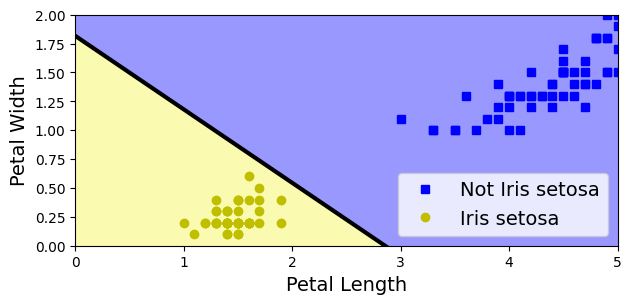

In [78]:
plot_decision_boundary(per_clf, X, y, 'Petal Length', 'Petal Width')

**Activation functions**

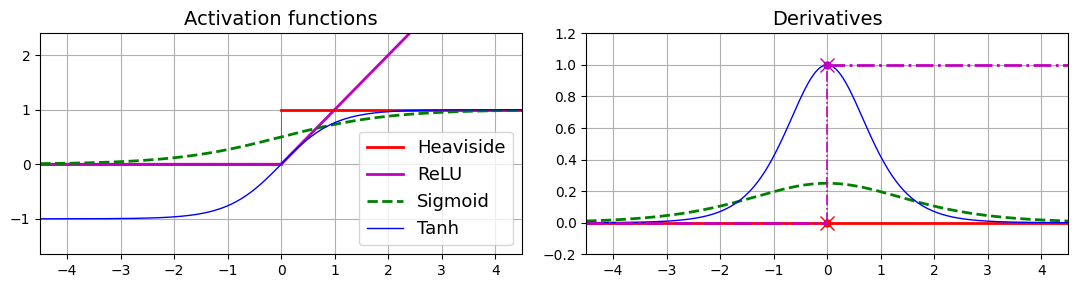

In [79]:
from scipy.special import expit as sigmoid

def relu(z):
    return np.maximum(0, z)

def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps)) / (2 * eps)

max_z = 4.5
z = np.linspace(-max_z, max_z, 200)

plt.figure(figsize=(11, 3.1))

plt.subplot(121)
plt.plot([-max_z, 0], [0, 0], "r-", linewidth=2, label="Heaviside")
plt.plot(z, relu(z), "m-", linewidth=2, label="ReLU")
plt.plot([0, 0], [0, 1], "r-", linewidth=0.5)
plt.plot([0, max_z], [1, 1], "r-", linewidth=2)
plt.plot(z, sigmoid(z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, np.tanh(z), "b-", linewidth=1, label="Tanh")
plt.grid(True)
plt.title("Activation functions")
plt.axis([-max_z, max_z, -1.65, 2.4])
plt.gca().set_yticks([-1, 0, 1, 2])
plt.legend(loc="lower right", fontsize=13)

plt.subplot(122)
plt.plot(z, derivative(np.sign, z), "r-", linewidth=2, label="Heaviside")
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot(z, derivative(sigmoid, z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, derivative(np.tanh, z), "b-", linewidth=1, label="Tanh")
plt.plot([-max_z, 0], [0, 0], "m-.", linewidth=2)
plt.plot([0, max_z], [1, 1], "m-.", linewidth=2)
plt.plot([0, 0], [0, 1], "m-.", linewidth=1.2)
plt.plot(0, 1, "mo", markersize=5)
plt.plot(0, 1, "mx", markersize=10)
plt.grid(True)
plt.title("Derivatives")
plt.axis([-max_z, max_z, -0.2, 1.2])

save_fig("activation_functions_plot")
plt.show()

## Regression MLPs

In [80]:
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, 
                                                              random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full,
                                                  random_state=42)

mlp_reg = MLPRegressor(hidden_layer_sizes=[50, 50, 50], random_state=42)
pipeline = make_pipeline(StandardScaler(), mlp_reg)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)
rmse = mean_squared_error(y_val, y_pred, squared=False)
rmse

0.5053326657968725

## Classification MLPs

In [81]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

iris = load_iris()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    iris.data, iris.target, test_size=0.1, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, test_size=0.1, random_state=42)

mlp_clf = MLPClassifier(hidden_layer_sizes=[5], max_iter=10_000,
                        random_state=42)
pipeline = make_pipeline(StandardScaler(), mlp_clf)
pipeline.fit(X_train, y_train)
accuracy = pipeline.score(X_valid, y_valid)
accuracy

1.0

# Implementing MLPs with Keras
## Building an Image Classifier using the Sequential API
### Using Keras to load the dataset

In [82]:
import tensorflow as tf

fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_val, y_val = X_train_full[-5000:], y_train_full[-5000:]

In [83]:
X_train.shape

(55000, 28, 28)

In [84]:
X_train.dtype

dtype('uint8')

In [85]:
X_train, X_val, X_test = X_train / 255, X_val / 255, X_test / 255

In [86]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

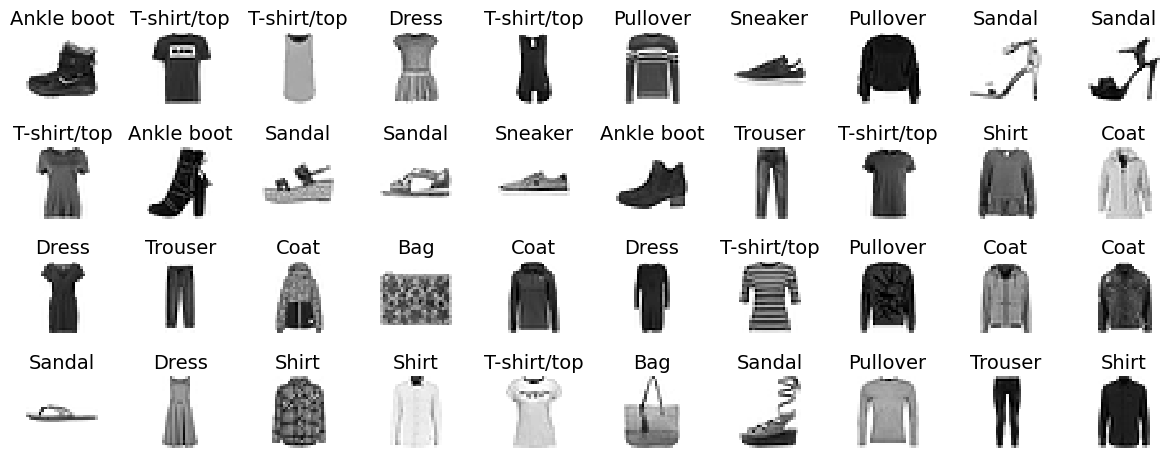

In [87]:
# extra code
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        idx = n_cols * row + col
        plt.subplot(n_rows, n_cols, idx + 1)
        plt.imshow(X_train[idx], cmap='binary', interpolation='nearest')
        plt.axis('off')
        plt.title(class_names[y_train[idx]])
    
plt.subplots_adjust(wspace=0.2, hspace=0.2)

save_fig('fashion_mnist_plot')
plt.show()

### Creating the model using the Sequential API

In [88]:
tf.random.set_seed(42)
model = tf.keras.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=[28, 28]))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(300, activation='relu'))
model.add(tf.keras.layers.Dense(100, activation='relu'))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

In [89]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [90]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


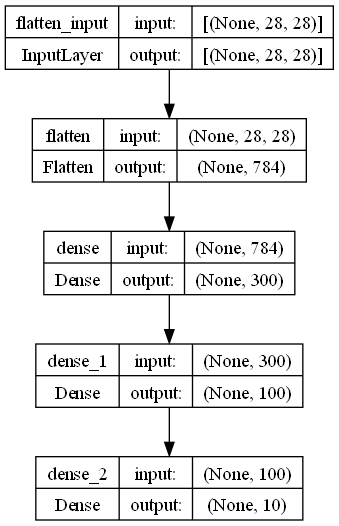

In [91]:
# another way to display the model's architecture
tf.keras.utils.plot_model(model, 'my_fashion_mnist_model.png', show_shapes=True)

In [92]:
model.layers

In [93]:
hidden1 = model.layers[1]
hidden1.name

'dense'

In [94]:
model.get_layer('dense') is hidden1

True

In [95]:
weights, biases = hidden1.get_weights()
weights

array([[ 0.02840474, -0.01030965, -0.06979068, ..., -0.01425716,
         0.0111136 , -0.01093885],
       [ 0.05429423,  0.0114042 , -0.04033653, ...,  0.02029443,
        -0.05068022, -0.0697553 ],
       [-0.07227778,  0.00514516, -0.06008829, ..., -0.0183221 ,
         0.06510995, -0.02072968],
       ...,
       [ 0.03169098,  0.04333022, -0.05050648, ..., -0.06412128,
        -0.04620947, -0.05819586],
       [ 0.018029  , -0.07055125,  0.06447387, ...,  0.06375732,
        -0.05929069, -0.02380149],
       [-0.05314736,  0.00630352,  0.00899231, ...,  0.0633762 ,
        -0.06600555,  0.00563512]], dtype=float32)

In [96]:
weights.shape

(784, 300)

In [97]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [98]:
biases.shape

(300,)

### Compiling the model

In [99]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

In [100]:
# extra code – shows how to convert one-hot vectors to class ids
np.argmax(
    [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
     [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
     [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
     [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
    axis=1
)

array([0, 5, 1, 0], dtype=int64)

If you want to convert sparse labels (i.e., class indices) to one-hot vector labels, use the `tf.keras.utils.to_categorical()` function. To go the other way round, use the `np.argmax()` function with axis=1.

### Training and evaluating the model

In [101]:
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_val, y_val))

Epoch 1/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.7197 - accuracy: 0.7656 - val_loss: 0.5091 - val_accuracy: 0.8280
Epoch 2/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4884 - accuracy: 0.8304 - val_loss: 0.4695 - val_accuracy: 0.8324
Epoch 3/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4423 - accuracy: 0.8449 - val_loss: 0.4267 - val_accuracy: 0.8510
Epoch 4/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4169 - accuracy: 0.8539 - val_loss: 0.3975 - val_accuracy: 0.8612
Epoch 5/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3956 - accuracy: 0.8612 - val_loss: 0.3939 - val_accuracy: 0.8602
Epoch 6/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3785 - accuracy: 0.8668 - val_loss: 0.3924 - val_accuracy: 0.8616
Epoch 7/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3656 - accuracy: 0.8698 - val_loss: 0.3727 - val_accuracy:

In [102]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 1719}

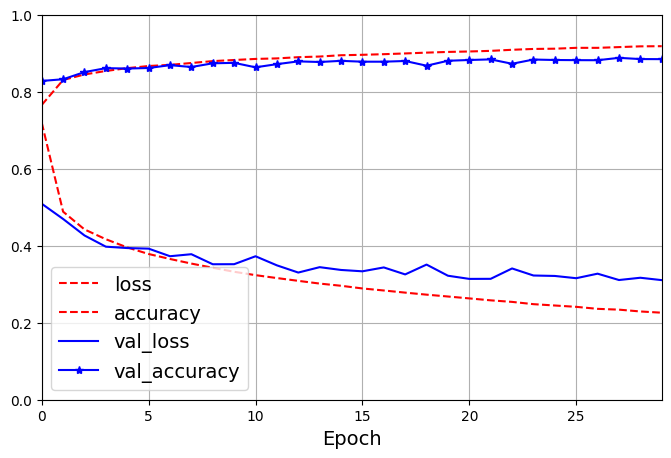

In [103]:
import matplotlib.pyplot as plt
import pandas as pd

pd.DataFrame(history.history).plot(
    figsize=(8, 5), xlim=[0, 29], ylim=[0, 1], grid=True, xlabel='Epoch',
    style=['r--', 'r--', 'b-', 'b-*']
)
plt.legend(loc='lower left')
plt.show()

In [104]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.3226 - accuracy: 0.8843


[0.32262122631073, 0.8842999935150146]

### Using the model to make predictions

In [105]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

1/1 [==============================] - 0s 52ms/step


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.03, 0.  , 0.96],
       [0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

In [106]:
y_pred = y_proba.argmax(axis=-1)
y_pred

array([9, 2, 1], dtype=int64)

In [107]:
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

In [108]:
y_new = y_test[:3]
y_new

array([9, 2, 1], dtype=uint8)

## Building a Regression MLP using the Sequential API

In [109]:
housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, random_state=42)

In [110]:
tf.random.set_seed(42)
norm_layer = tf.keras.layers.Normalization(input_shape=X_train.shape[1:])
model = tf.keras.Sequential([
    norm_layer,
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(1)
])
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss='mse', optimizer=optimizer, metrics=['RootMeanSquaredError'])
norm_layer.adapt(X_train)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_val, y_val))
mse_test, rmse_test = model.evaluate(X_test, y_test)
X_new = X_test[:3]
y_pred = model.predict(X_new)

Epoch 1/20
363/363 [==============================] - 2s 4ms/step - loss: 0.8986 - root_mean_squared_error: 0.9480 - val_loss: 0.4248 - val_root_mean_squared_error: 0.6518
Epoch 2/20
363/363 [==============================] - 1s 3ms/step - loss: 0.3799 - root_mean_squared_error: 0.6164 - val_loss: 1.4890 - val_root_mean_squared_error: 1.2202
Epoch 3/20
363/363 [==============================] - 1s 3ms/step - loss: 0.3644 - root_mean_squared_error: 0.6036 - val_loss: 0.3761 - val_root_mean_squared_error: 0.6133
Epoch 4/20
363/363 [==============================] - 1s 3ms/step - loss: 0.3411 - root_mean_squared_error: 0.5840 - val_loss: 0.6791 - val_root_mean_squared_error: 0.8241
Epoch 5/20
363/363 [==============================] - 1s 3ms/step - loss: 0.3310 - root_mean_squared_error: 0.5753 - val_loss: 1.2519 - val_root_mean_squared_error: 1.1189
Epoch 6/20
363/363 [==============================] - 1s 3ms/step - loss: 0.3262 - root_mean_squared_error: 0.5712 - val_loss: 0.3335 - val_

In [111]:
rmse_test

0.5329038500785828

In [112]:
y_pred

array([[0.4599257],
       [1.2164911],
       [5.2752075]], dtype=float32)

## Building Complex Models Using the Functional API

Not all neural networks are simply sequential. Some may have complex topologies. Some may have multiple inputs and/or multiple outputs. For example, a Wide & Deep neural network connects all or part of the inputs directly to the output layer.

In [113]:
# reset the name counters and make the code reproducible
tf.keras.backend.clear_session()
tf.random.set_seed(42)

*Wide & Deep neural network*

In [114]:
# the following 5 lines create all the layers we need to build the model
normalization_layer = tf.keras.layers.Normalization()
hidden_layer1 = tf.keras.layers.Dense(30, activation="relu")
hidden_layer2 = tf.keras.layers.Dense(30, activation="relu")
concat_layer = tf.keras.layers.Concatenate()
output_layer = tf.keras.layers.Dense(1)

# next six lines use the above created layers to go from the input to the output
input_ = tf.keras.layers.Input(shape=X_train.shape[1:])
normalized = normalization_layer(input_)
hidden1 = hidden_layer1(normalized)
hidden2 = hidden_layer2(hidden1)
concat = concat_layer([normalized, hidden2])
output = output_layer(concat)

# NOTE: We are just telling Keras how it should connect the layers together; 
# no actual data is being processed yet, as the Input object is just a data specification.
# In other words, it's a symbolic input

# next line creates a Keras Model object by pointing to the input and the output
model = tf.keras.Model(inputs=[input_], outputs=[output])

In [115]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 8)]          0           []                               
                                                                                                  
 normalization (Normalization)  (None, 8)            17          ['input_1[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 30)           270         ['normalization[0][0]']          
                                                                                                  
 dense_1 (Dense)                (None, 30)           930         ['dense[0][0]']                  
                                                                                              

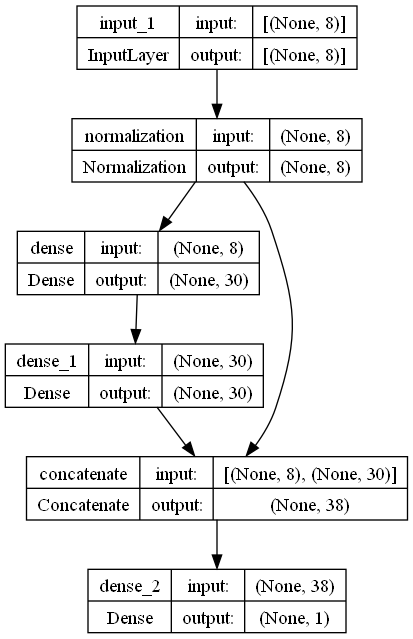

In [116]:
tf.keras.utils.plot_model(model, "California_housing_model.png", show_shapes=True)

In [117]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])
normalization_layer.adapt(X_train)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_val, y_val))
mse_test = model.evaluate(X_test, y_test)
y_pred = model.predict(X_new)

Epoch 1/20
363/363 [==============================] - 2s 4ms/step - loss: 1.3014 - root_mean_squared_error: 1.1408 - val_loss: 8.2026 - val_root_mean_squared_error: 2.8640
Epoch 2/20
363/363 [==============================] - 1s 3ms/step - loss: 0.5028 - root_mean_squared_error: 0.7090 - val_loss: 3.3548 - val_root_mean_squared_error: 1.8316
Epoch 3/20
363/363 [==============================] - 1s 3ms/step - loss: 0.4136 - root_mean_squared_error: 0.6431 - val_loss: 0.9528 - val_root_mean_squared_error: 0.9761
Epoch 4/20
363/363 [==============================] - 1s 3ms/step - loss: 0.3777 - root_mean_squared_error: 0.6146 - val_loss: 0.3785 - val_root_mean_squared_error: 0.6152
Epoch 5/20
363/363 [==============================] - 1s 3ms/step - loss: 0.3619 - root_mean_squared_error: 0.6016 - val_loss: 0.3812 - val_root_mean_squared_error: 0.6174
Epoch 6/20
363/363 [==============================] - 1s 3ms/step - loss: 0.3531 - root_mean_squared_error: 0.5943 - val_loss: 0.3932 - val_

In [121]:
tf.random.set_seed(42)

In [123]:
input_wide = tf.keras.layers.Input(shape=[5])  # features 0 to 4
input_deep = tf.keras.layers.Input(shape=[6])  # features 2 to 7
norm_layer_wide = tf.keras.layers.Normalization()
norm_layer_deep = tf.keras.layers.Normalization()
norm_wide = norm_layer_wide(input_wide)
norm_deep = norm_layer_deep(input_deep)
hidden1 = tf.keras.layers.Dense(30, activation="relu")(norm_deep)
hidden2 = tf.keras.layers.Dense(30, activation="relu")(hidden1)
concat = tf.keras.layers.Concatenate()([norm_wide, hidden2])
output = tf.keras.layers.Dense(1)(concat)
model = tf.keras.Model(inputs=[input_wide, input_deep], outputs=[output])

In [125]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])

X_train_wide, X_train_deep = X_train[:, :5], X_train[:, 2:]
X_val_wide, X_val_deep = X_val[:, :5], X_val[:, 2:]
X_test_wide, X_test_deep = X_test[:, :5], X_test[:, 2:]
X_new_wide, X_new_deep = X_test_wide[:3], X_test_deep[:3]

norm_layer_wide.adapt(X_train_wide)
norm_layer_deep.adapt(X_train_deep)
history = model.fit((X_train_wide, X_train_deep), y_train, epochs=20,
                    validation_data=((X_val_wide, X_val_deep), y_val))
mse_test = model.evaluate((X_test_wide, X_test_deep), y_test)
y_pred = model.predict((X_new_wide, X_new_deep))

Epoch 1/20
363/363 [==============================] - 2s 4ms/step - loss: 1.6944 - root_mean_squared_error: 1.3017 - val_loss: 0.9113 - val_root_mean_squared_error: 0.9546
Epoch 2/20
363/363 [==============================] - 1s 3ms/step - loss: 0.5619 - root_mean_squared_error: 0.7496 - val_loss: 1.6686 - val_root_mean_squared_error: 1.2918
Epoch 3/20
363/363 [==============================] - 1s 3ms/step - loss: 0.4738 - root_mean_squared_error: 0.6883 - val_loss: 0.4114 - val_root_mean_squared_error: 0.6414
Epoch 4/20
363/363 [==============================] - 1s 4ms/step - loss: 0.4179 - root_mean_squared_error: 0.6464 - val_loss: 0.9143 - val_root_mean_squared_error: 0.9562
Epoch 5/20
363/363 [==============================] - 1s 4ms/step - loss: 0.3895 - root_mean_squared_error: 0.6241 - val_loss: 0.6882 - val_root_mean_squared_error: 0.8296
Epoch 6/20
363/363 [==============================] - 1s 3ms/step - loss: 0.3787 - root_mean_squared_error: 0.6154 - val_loss: 0.8085 - val_

Instead of passing a tuple `(X_train_wide, X_train_deep)`, you can pass a dictionary `{"input_wide": X_train_wide, "input_deep": X_train_deep}`, if you set name="input_deep" when creating the inputs. This is highly recommended when there are many inputs, to clarify the code and avoid getting the order wrong.

Adding an auxiliary output for regularization

In [127]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [129]:
input_wide = tf.keras.layers.Input(shape=[5])  # features 0 to 4
input_deep = tf.keras.layers.Input(shape=[6])  # features 2 to 7
norm_layer_wide = tf.keras.layers.Normalization()
norm_layer_deep = tf.keras.layers.Normalization()
norm_wide = norm_layer_wide(input_wide)
norm_deep = norm_layer_deep(input_deep)
hidden1 = tf.keras.layers.Dense(30, activation="relu")(norm_deep)
hidden2 = tf.keras.layers.Dense(30, activation="relu")(hidden1)
concat = tf.keras.layers.Concatenate()([norm_wide, hidden2])
output = tf.keras.layers.Dense(1)(concat)
aux_output = tf.keras.layers.Dense(1)(hidden2)
model = tf.keras.Model(inputs=[input_wide, input_deep],
                        outputs=[output, aux_output])

In [131]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss=("mse", "mse"), loss_weights=(0.9, 0.1), optimizer=optimizer,
                metrics=["RootMeanSquaredError"])

In [132]:
norm_layer_wide.adapt(X_train_wide)
norm_layer_deep.adapt(X_train_deep)
history = model.fit(
    (X_train_wide, X_train_deep), (y_train, y_train), epochs=20,
    validation_data=((X_val_wide, X_val_deep), (y_val, y_val))
)

Epoch 1/20
363/363 [==============================] - 3s 6ms/step - loss: 2.0750 - dense_5_loss: 2.0171 - dense_6_loss: 2.5964 - dense_5_root_mean_squared_error: 1.4202 - dense_6_root_mean_squared_error: 1.6113 - val_loss: 1.7404 - val_dense_5_loss: 0.9579 - val_dense_6_loss: 8.7826 - val_dense_5_root_mean_squared_error: 0.9787 - val_dense_6_root_mean_squared_error: 2.9636
Epoch 2/20
363/363 [==============================] - 2s 5ms/step - loss: 0.6799 - dense_5_loss: 0.6628 - dense_6_loss: 0.8333 - dense_5_root_mean_squared_error: 0.8142 - dense_6_root_mean_squared_error: 0.9128 - val_loss: 1.3502 - val_dense_5_loss: 1.0334 - val_dense_6_loss: 4.2012 - val_dense_5_root_mean_squared_error: 1.0166 - val_dense_6_root_mean_squared_error: 2.0497
Epoch 3/20
363/363 [==============================] - 2s 5ms/step - loss: 0.5560 - dense_5_loss: 0.5476 - dense_6_loss: 0.6321 - dense_5_root_mean_squared_error: 0.7400 - dense_6_root_mean_squared_error: 0.7950 - val_loss: 0.6185 - val_dense_5_loss

In [134]:
eval_results = model.evaluate((X_test_wide, X_test_deep), (y_test, y_test))
weighted_sum_of_losses, main_loss, aux_loss, main_rmse, aux_rmse = eval_results

162/162 [==============================] - 1s 3ms/step - loss: 0.3399 - dense_5_loss: 0.3336 - dense_6_loss: 0.3972 - dense_5_root_mean_squared_error: 0.5776 - dense_6_root_mean_squared_error: 0.6302


In [135]:
y_pred_main, y_pred_aux = model.predict((X_new_wide, X_new_deep))

1/1 [==============================] - 0s 69ms/step


In [136]:
y_pred_tuple = model.predict((X_new_wide, X_new_deep))
y_pred = dict(zip(model.output_names, y_pred_tuple))

1/1 [==============================] - 0s 21ms/step


## Using the Subclassing API to Build Dynamic Models